# Image Preprocessing for quantitative discrimination of dried blood droplets

An example notebook, trying to reproduce the preprocessing steps as presented in [Machine Learning Analysis for
Quantitative Discrimination of
Dried Blood Droplets](https://www.nature.com/articles/s41598-020-59847-x.pdf)

In [1]:
from pathlib import Path
from PIL import Image, ImageOps, ImageFilter
from ipywidgets.widgets import HBox, Output
from IPython.display import display
import numpy as np
import cv2
from scipy.interpolate import griddata

## Example image

For testing the pipeline we are using the below image for trial person 1 after 2 mins image 6

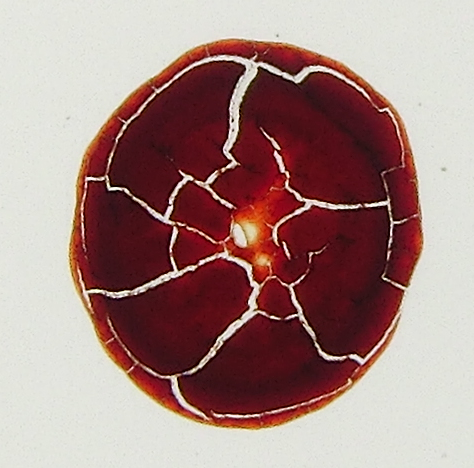

In [2]:
path = Path('./data/person_1_after2_6.tif')
img = Image.open(path)
img

### Crack detection

As described in the paper cracks are detected using a simple treshold criteria:  $I^R(x,y)[I^{G,B}(x,y)>\alpha]$.
Translated: the cracks are in regions in the red channel ($R$) where intensity ($I$)  values in the green ($G$) and blue ($B$) channel are above a certain treshhold $\alpha$.

In [3]:
def image_output(img, color='black'):
    img = ImageOps.colorize(img, black='black', white=color)
    out = Output()
    with out:

        display(img)
    return out
red, green, blue = img.split()
HBox([image_output(red, 'red'), image_output(green, 'green'), image_output(blue, 'blue')])

In [4]:
RED_TRESH = 150

def find_cell(img):
    # turn into binary for findContours using simple treshholding >RED_TRESH
    binary = np.ones_like(img)
    binary[np.array(img)>RED_TRESH] = 0
    #  find hull of cell for a smooth mask   
    contours, _ = cv2.findContours(np.array(binary), cv2.cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours.sort(key=lambda c: cv2.contourArea(c), reverse=True)
    hull = cv2.convexHull(contours[0])
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [hull], 0, (1), cv2.FILLED)
    return mask


ALPHA = 100

def detect_cracks(red, green, blue):
    cell = find_cell(red)
    mask = np.zeros_like(red)
    mask[(cell>0)& (np.array(blue)>ALPHA) & (np.array(green)>ALPHA)] = 1
    return mask
mask = detect_cracks(red, green,blue)

### Show cracks

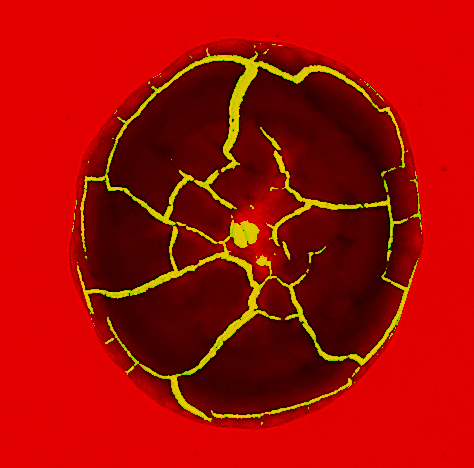

In [143]:
Image.fromarray(np.dstack((np.array(red), 200*mask, 0*mask)))

## Crack interpolation

We use the created mask of cracks from above and interpolate them using `griddata` from scipy. The _linear_ and _cubic_ method give black line on lower edge so we are using _nearest_.

In [5]:
red_arr = np.array(red)
ny, nx = red_arr.shape
grid_x, grid_y = np.mgrid[0:nx, 0:ny]
points = np.argwhere(mask<1)
values = red_arr[mask<1]
points.shape, values.shape

In [86]:
interpolated_img = griddata( points, values, (grid_x, grid_y), method='nearest')

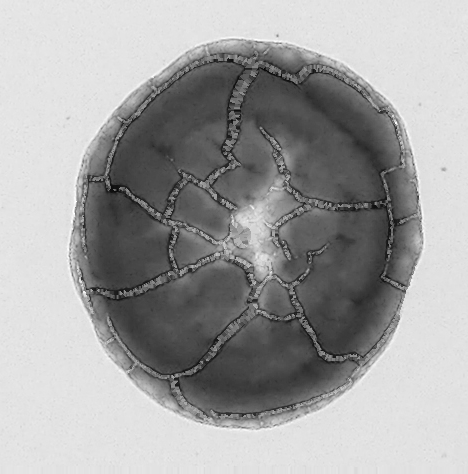

In [87]:
Image.fromarray(interpolated_img.astype(np.uint8))

## Gaussian blur

To remove high frequency components and smoothen out quick intensity chances, we use a Gaussian blur.

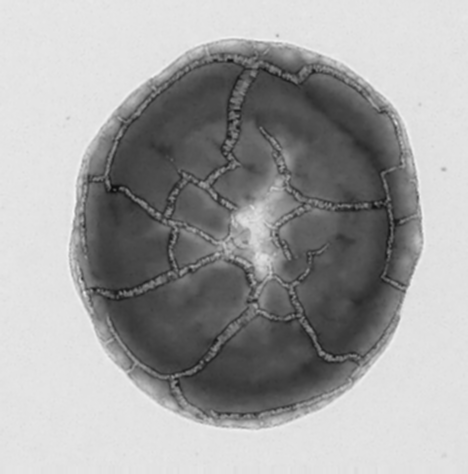

In [96]:
blur = cv2.GaussianBlur(interpolated_img,(3,3),1)
Image.fromarray(blur)